# Qiskit ExactReciprocal

This notebook demonstrates the Qiskit `ExactReciprocal` component.

* [Qiskit ExactReciprocal documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ExactReciprocal)

The documentation states that the `ExactReciprocal` operation takes the state $|x\rangle|0\rangle$ to:
$$
\cos(\frac{1}{x})|x\rangle|0\rangle + \sin(\frac{1}{x})|x\rangle|1\rangle
$$

However, this is not quite correct. We have found that the operation actually takes the state $|x\rangle|0\rangle$ to:
$$
\sqrt{1-\left(\frac{1}{x}\right)^2}|x\rangle|0\rangle + \frac{1}{x}|x\rangle|1\rangle
$$

As well as the number of qubits for the input value, the operation takes two further parameters:

* `scaling`: Scaling factor $s$ of the reciprocal function, i.e. to compute $s/x$.
* `neg_vals` (Boolean): Whether $x$ might represent negative values. In this case the first qubit is the sign, with $|1\rangle$ for negative and $|0\rangle$ for positive. For the negative case it is assumed that the remaining string represents $1-x$. This is because $e^{-2\pi ix}=e^{2\pi i(1-x)}$ for $x\in[0,1]$.

If we choose `scaling`=$\frac{1}{2^n}$, where $n$ is the number of clock (state) qubits, then our input $x$ is interpreted as a binary fraction $0.x_1x_2\ldots x_n$.

The examples below first show how the `ExactReciprocal` operation works for this choice of `scaling` and positive $x$, 
and then show some other variants.
Note that the way the circuit is wired up, the `ExactReciprocal` operates on $|0\rangle|x\rangle$ rather than $|x\rangle|0\rangle$.
Jack Morgan's HHL circuit uses `neg_vals=True`.

## See also:

* [Jack Morgan's Enhanced HHL code](https://github.com/jackhmorgan/Enhanced-Hybrid-HHL)

In [1]:
import numpy as np
from IPython.display import display, Markdown
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import ExactReciprocal, StatePreparation
from qiskit.quantum_info import Statevector


def create_input_circuit(input):
    """Create a circuit that prepares the input state."""
    x = np.array(input) / np.linalg.norm(input)
    state_vector = Statevector(x)
    x_reg = QuantumRegister(state_vector.num_qubits, 'x')
    circuit = QuantumCircuit(x_reg)
    circuit.append(StatePreparation(state_vector), x_reg)
    return circuit


def create_exact_reciprocal_circuit(input, scaling_factor=1, neg_vals=False):
    """Create a circuit that computes the exact reciprocal of the input state."""
    circuit = create_input_circuit(input)
    num_state_qubits = circuit.num_qubits - 1
    scaling = 2**(-num_state_qubits) * scaling_factor
    exact_reciprocal = ExactReciprocal(num_state_qubits=num_state_qubits, scaling=scaling, neg_vals=neg_vals)
    circuit.append(exact_reciprocal, circuit.qubits)
    return circuit


def run_circuit(circuit):
    """Run the circuit on the statevector simulator and return the output state."""
    simulator = Aer.get_backend('statevector_simulator')
    aer_circuit = transpile(circuit, simulator)
    return simulator.run(aer_circuit).result().get_statevector()


def latex_circuit_output(circuit):
    """Return the LaTeX representation of the output state of the circuit, suitable for display in a IPython Markdown cell."""
    return run_circuit(circuit).draw(output='latex').data.replace('|', r'\|')


def latex_source_circuit_output(circuit):
    """Return the LaTeX source code representation of the output state of the circuit, suitable for copy+paste to a LaTeX file."""
    return run_circuit(circuit).draw(output='latex_source').replace('|', r'\|')


def run_table(vals, scaling_factor=1, neg_vals=False):
    """Displays a table of ExactReciprocal inputs and outputs in Jupyter notebook."""
    markdowntable = f"""
| Input $x$ | Input State | Output State | Output $\\frac{{s}}{{x}}$ |
|-----------|-------------|--------------|---------------------------|
"""
    for val in vals:
        input = val["input"]
        input_vec = val["input_vec"]
        output = val["output"]
        input_state = latex_circuit_output(create_input_circuit(input_vec))
        output_state = latex_circuit_output(create_exact_reciprocal_circuit(input_vec, scaling_factor, neg_vals))
        if scaling_factor == 1:
            markdowntable += f"| {input} | {input_state} | {output_state} | {output} | \n"
        else:
            markdowntable += f"| {input_state} | {output_state} | \n"
    display(Markdown(markdowntable))


def run_table_for_latex_source(vals, scaling_factor=1, neg_vals=False):
    """Displays a table of ExactReciprocal inputs and outputs in LaTeX source format."""
    result = f"""
"""
    for val in vals:
        input = val["input"]
        input_vec = val["input_vec"]
        output = val["output"]
        input_state = latex_source_circuit_output(create_input_circuit(input_vec))
        output_state = latex_source_circuit_output(create_exact_reciprocal_circuit(input_vec, scaling_factor, neg_vals))
        if scaling_factor == 1:
            result += f"{input} & ${input_state}$ & ${output_state}$ & {output} \\\\\n"
        else:
            result += f"${input_state}$ & ${output_state}$ \\\\\n"
    print(result)


vals2 = [
    {"input": "$0$"           , "input_vec": [1, 0, 0, 0, 0, 0, 0, 0], "output": "undefined"},       # |0>|00>
    {"input": "$\\frac{1}{4}$", "input_vec": [0, 1, 0, 0, 0, 0, 0, 0], "output": "$1$"},             # |0>|01>
    {"input": "$\\frac{1}{2}$", "input_vec": [0, 0, 1, 0, 0, 0, 0, 0], "output": "$\\frac{1}{2}$"},  # |0>|10>
    {"input": "$\\frac{3}{4}$", "input_vec": [0, 0, 0, 1, 0, 0, 0, 0], "output": "$\\frac{1}{3}$"},  # |0>|11>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 1, 0, 0, 0], "output": ""},                # |1>|00>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 1, 0, 0], "output": ""},                # |1>|01>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 1, 0], "output": ""},                # |1>|10>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 1], "output": ""},                # |1>|11>
]

vals3 = [
    {"input": "$0$"           , "input_vec": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "undefined"},      # |0>|000>
    {"input": "$\\frac{1}{8}$", "input_vec": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$1$"},            # |0>|001>
    {"input": "$\\frac{1}{4}$", "input_vec": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{2}$"}, # |0>|010>
    {"input": "$\\frac{3}{8}$", "input_vec": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{3}$"}, # |0>|011>
    {"input": "$\\frac{1}{2}$", "input_vec": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{4}$"}, # |0>|100>
    {"input": "$\\frac{5}{8}$", "input_vec": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{5}$"}, # |0>|101>
    {"input": "$\\frac{3}{4}$", "input_vec": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{6}$"}, # |0>|110>
    {"input": "$\\frac{7}{8}$", "input_vec": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], "output": "$\\frac{1}{7}$"}, # |0>|111>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], "output": ""},               # |1>|000>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], "output": ""},               # |1>|001>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "output": ""},               # |1>|010>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], "output": ""},               # |1>|011>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], "output": ""},               # |1>|100>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], "output": ""},               # |1>|101>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "output": ""},               # |1>|110>
    {"input": "(N/A)"         , "input_vec": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], "output": ""},               # |1>|111>
]

## ExactReciprocal for 2 qubits

The table below shows the inputs and outputs of `ExactReciprocal` for 2 qubits, with default scaling and no negative values.

In [2]:
run_table(vals2)


| Input $x$ | Input State | Output State | Output $\frac{s}{x}$ |
|-----------|-------------|--------------|---------------------------|
| $0$ | $$ \|000\rangle$$ | $$ \|000\rangle$$ | undefined | 
| $\frac{1}{4}$ | $$ \|001\rangle$$ | $$ \|101\rangle$$ | $1$ | 
| $\frac{1}{2}$ | $$ \|010\rangle$$ | $$\frac{\sqrt{3}}{2} \|010\rangle+\frac{1}{2} \|110\rangle$$ | $\frac{1}{2}$ | 
| $\frac{3}{4}$ | $$ \|011\rangle$$ | $$\frac{2 \sqrt{2}}{3} \|011\rangle+\frac{1}{3} \|111\rangle$$ | $\frac{1}{3}$ | 
| (N/A) | $$ \|100\rangle$$ | $$ \|100\rangle$$ |  | 
| (N/A) | $$ \|101\rangle$$ | $$- \|001\rangle$$ |  | 
| (N/A) | $$ \|110\rangle$$ | $$- \frac{1}{2} \|010\rangle+\frac{\sqrt{3}}{2} \|110\rangle$$ |  | 
| (N/A) | $$ \|111\rangle$$ | $$- \frac{1}{3} \|011\rangle+\frac{2 \sqrt{2}}{3} \|111\rangle$$ |  | 


## ExactReciprocal for 3 qubits

The table below shows the inputs and outputs of `ExactReciprocal` for 3 qubits, with default scaling and no negative values.

In [3]:
run_table(vals3)


| Input $x$ | Input State | Output State | Output $\frac{s}{x}$ |
|-----------|-------------|--------------|---------------------------|
| $0$ | $$ \|0000\rangle$$ | $$ \|0000\rangle$$ | undefined | 
| $\frac{1}{8}$ | $$ \|0001\rangle$$ | $$ \|1001\rangle$$ | $1$ | 
| $\frac{1}{4}$ | $$ \|0010\rangle$$ | $$\frac{\sqrt{3}}{2} \|0010\rangle+\frac{1}{2} \|1010\rangle$$ | $\frac{1}{2}$ | 
| $\frac{3}{8}$ | $$ \|0011\rangle$$ | $$\frac{2 \sqrt{2}}{3} \|0011\rangle+\frac{1}{3} \|1011\rangle$$ | $\frac{1}{3}$ | 
| $\frac{1}{2}$ | $$ \|0100\rangle$$ | $$\frac{\sqrt{15}}{4} \|0100\rangle+\frac{1}{4} \|1100\rangle$$ | $\frac{1}{4}$ | 
| $\frac{5}{8}$ | $$ \|0101\rangle$$ | $$0.9797958971 \|0101\rangle+\frac{1}{5} \|1101\rangle$$ | $\frac{1}{5}$ | 
| $\frac{3}{4}$ | $$ \|0110\rangle$$ | $$0.9860132972 \|0110\rangle+\frac{1}{6} \|1110\rangle$$ | $\frac{1}{6}$ | 
| $\frac{7}{8}$ | $$ \|0111\rangle$$ | $$0.9897433186 \|0111\rangle+\frac{1}{7} \|1111\rangle$$ | $\frac{1}{7}$ | 
| (N/A) | $$ \|1000\rangle$$ | $$ \|1000\rangle$$ |  | 
| (N/A) | $$ \|1001\rangle$$ | $$- \|0001\rangle$$ |  | 
| (N/A) | $$ \|1010\rangle$$ | $$- \frac{1}{2} \|0010\rangle+\frac{\sqrt{3}}{2} \|1010\rangle$$ |  | 
| (N/A) | $$ \|1011\rangle$$ | $$- \frac{1}{3} \|0011\rangle+\frac{2 \sqrt{2}}{3} \|1011\rangle$$ |  | 
| (N/A) | $$ \|1100\rangle$$ | $$- \frac{1}{4} \|0100\rangle+\frac{\sqrt{15}}{4} \|1100\rangle$$ |  | 
| (N/A) | $$ \|1101\rangle$$ | $$- \frac{1}{5} \|0101\rangle+0.9797958971 \|1101\rangle$$ |  | 
| (N/A) | $$ \|1110\rangle$$ | $$- \frac{1}{6} \|0110\rangle+0.9860132972 \|1110\rangle$$ |  | 
| (N/A) | $$ \|1111\rangle$$ | $$- \frac{1}{7} \|0111\rangle+0.9897433186 \|1111\rangle$$ |  | 


# Diagrams

The `ExactReciprocal` implementation composes a circuit, and then makes the component available by creating a gate that encapsulates the circuit.
The code snippet below shows how this is done:

```python
    super().__init__(*circuit.qregs, name=name)
    self.compose(circuit.to_gate(), qubits=self.qubits, inplace=True)
```

Because of this, when we render a circuit containing an `ExactReciprocal` gate, we see a single gate, and not the internal structure.
The cell below shows the 2-qubit `ExactReciprocal` as a single gate as created by the Qiskit library.

To examine the internal structure in more detail, we can copy the Qiskit source code and modify it.
The next cell shows the implementation of `ExactReciprocal` in terms of the Qiskit `UCRYGate`. 
This is actually not much of an improvement, although it does show the rotation angles: 0, $\pi$, $\pi/3$ and $0.68=2\sin^{-1}(1/3)$.

To get more detail, we could try the same approach with the `UCRYGate` source code, but this leads us quickly down into the internal depths of the Qiskit library.
Instead, we can code the circuit explicitly using the analysis from the Project report.

# ExactReciprocal as rendered by Qiskit library

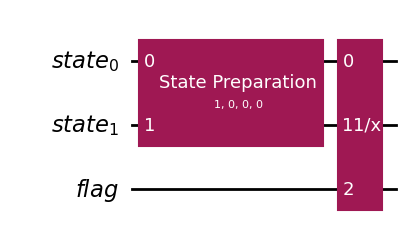

In [20]:
num_qubits = 3
num_state_qubits = num_qubits - 1
scaling = 2**(-num_state_qubits)
qr_state = QuantumRegister(num_state_qubits, "state")
qr_flag = QuantumRegister(1, "flag")
circuit = QuantumCircuit(qr_state, qr_flag, name="1/x")
circuit.append(StatePreparation([1, 0, 0, 0]), qr_state)
exact_reciprocal = ExactReciprocal(num_state_qubits=num_state_qubits, scaling=scaling, neg_vals=False)
circuit.append(exact_reciprocal, circuit.qubits)
display(Markdown("# ExactReciprocal as rendered by Qiskit library"))
display(circuit.draw(output='mpl'))

# ExactReciprocal as rendered by UCRYGate

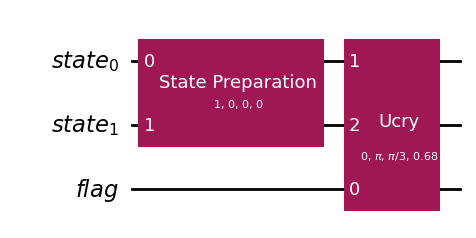

In [21]:
from math import isclose
from qiskit.circuit.library.generalized_gates import UCRYGate

num_qubits = 3
num_state_qubits = num_qubits - 1
scaling = 2**(-num_state_qubits)
qr_state = QuantumRegister(num_state_qubits, "state")
qr_flag = QuantumRegister(1, "flag")
circuit = QuantumCircuit(qr_state, qr_flag, name="1/x")
circuit.append(StatePreparation([1, 0, 0, 0]), qr_state)
angles = [0.0]
nl = 2**num_state_qubits
for i in range(1, nl):
    if isclose(scaling * nl / i, 1, abs_tol=1e-5):
        angles.append(np.pi)
    elif scaling * nl / i < 1:
        angles.append(2 * np.arcsin(scaling * nl / i))
    else:
        angles.append(0.0)
circuit.compose(
    UCRYGate(angles), [qr_flag[0]] + qr_state[: len(qr_state)], inplace=True
)
display(Markdown("# ExactReciprocal as rendered by UCRYGate"))
display(circuit.draw(output='mpl'))


# ExactReciprocal using CRY Gates

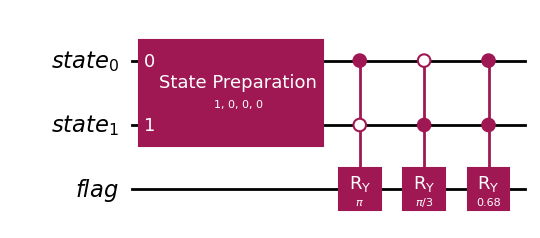

In [28]:
from qiskit.circuit.library import RYGate

num_qubits = 3
num_state_qubits = num_qubits - 1
scaling = 2**(-num_state_qubits)
qr_state = QuantumRegister(num_state_qubits, "state")
qr_flag = QuantumRegister(1, "flag")
circuit = QuantumCircuit(qr_state, qr_flag, name="1/x")
circuit.append(StatePreparation([1, 0, 0, 0]), qr_state)
nl = 2**num_state_qubits

for i in range(1, nl):
    if isclose(scaling * nl / i, 1, abs_tol=1e-5):
        angle = np.pi
    elif scaling * nl / i < 1:
        angle = 2 * np.arcsin(scaling * nl / i)
    else:
        angle = 0.0

    bits = f"{i:0{num_state_qubits}b}"
    RYi = RYGate(angle).control(num_state_qubits, ctrl_state=bits)
    circuit.append(RYi, [*qr_state, qr_flag[0]])

display(Markdown("# ExactReciprocal using CRY Gates"))
display(circuit.draw(output='mpl'))


In [ ]:
def create_input_circuit(input):
    num_qubits = 3
    num_state_qubits = num_qubits - 1
    scaling = 2**(-num_state_qubits)
    qr_state = QuantumRegister(num_state_qubits, "state")
    qr_flag = QuantumRegister(1, "flag")
    circuit = QuantumCircuit(qr_state, qr_flag, name="1/x")
    circuit.append(StatePreparation(input), qr_state)
    return circuit

def create_exact_reciprocal_circuit(input):
    num_qubits = 3
    num_state_qubits = num_qubits - 1
    scaling = 2**(-num_state_qubits)
    qr_state = QuantumRegister(num_state_qubits, "state")
    qr_flag = QuantumRegister(1, "flag")
    circuit = QuantumCircuit(qr_state, qr_flag, name="1/x")
    circuit.append(StatePreparation(input), qr_state)
    nl = 2**num_state_qubits

    for i in range(1, nl):
        bits = f"{i:0{num_state_qubits}b}"
        if isclose(scaling * nl / i, 1, abs_tol=1e-5):
            angle = np.pi
        elif scaling * nl / i < 1:
            angle = 2 * np.arcsin(scaling * nl / i)
        else:
            angle = 0.0

        RYi = RYGate(angle).control(num_state_qubits, ctrl_state=bits)
        circuit.append(RYi, [*qr_state, qr_flag[0]])
    return circuit


vals2 = [
    {"input": "$0$"           , "input_vec": [1, 0, 0, 0], "output": "undefined"},       # |0>|00>
    {"input": "$\\frac{1}{4}$", "input_vec": [0, 1, 0, 0], "output": "$1$"},             # |0>|01>
    {"input": "$\\frac{1}{2}$", "input_vec": [0, 0, 1, 0], "output": "$\\frac{1}{2}$"},  # |0>|10>
    {"input": "$\\frac{3}{4}$", "input_vec": [0, 0, 0, 1], "output": "$\\frac{1}{3}$"},  # |0>|11>
]

markdowntable = f"""
| Input $x$ | Input State | Output State | Output $\\frac{{s}}{{x}}$ |
|-----------|-------------|--------------|---------------------------|
"""
for val in vals2:
    input = val["input"]
    input_vec = val["input_vec"]
    output = val["output"]
    input_state = latex_circuit_output(create_input_circuit(input_vec))
    output_state = latex_circuit_output(create_exact_reciprocal_circuit(input_vec))
    markdowntable += f"| {input} | {input_state} | {output_state} | {output} | \n"
display(Markdown("# Verification of ExactReciprocal with CRY Gates"))
display(Markdown(markdowntable))


# Verification of ExactReciprocal with CRY Gates


| Input $x$ | Input State | Output State | Output $\frac{s}{x}$ |
|-----------|-------------|--------------|---------------------------|
| $0$ | $$ \|000\rangle$$ | $$ \|000\rangle$$ | undefined | 
| $\frac{1}{4}$ | $$ \|001\rangle$$ | $$ \|101\rangle$$ | $1$ | 
| $\frac{1}{2}$ | $$ \|010\rangle$$ | $$\frac{\sqrt{3}}{2} \|010\rangle+\frac{1}{2} \|110\rangle$$ | $\frac{1}{2}$ | 
| $\frac{3}{4}$ | $$ \|011\rangle$$ | $$\frac{2 \sqrt{2}}{3} \|011\rangle+\frac{1}{3} \|111\rangle$$ | $\frac{1}{3}$ | 
